# Linear Convection in 2D

ME469 - Computational Methods in Fluid Dynamics - Stanford University

Example #2

These examples are provided as part of the ME469 class (Spring 2018).

For comments or corrections, please contact jops at stanford dot edu

## Objective
Study the convergence rate of the solution to the linear convection equation using different finite difference schemes 

We wish to solve the transport of a contaminant $\phi$ in time. The mathematical model chosen is 2D linear convection equation using explicit finite difference schemes

$$\frac{\partial \phi} {\partial t} + u_x\frac{\partial \phi} {\partial x} + u_y\frac{\partial \phi} {\partial y}=0$$

$\phi$ is a scalar quantity (i.e. the concentration of a pollutant - defined in parts-per-million). We seek a solution using different numerical discretization.
Let's first define the exact solution, which is simply $\phi(t,x,y)=\phi_0(x-u_x t,y-u_y t)$ where $\phi_0(x,y)$ is the initial condition, and $u$ is a given convection velocity.

The numerical solution is defined as $\phi(x,y,t) \approx \phi(x_i,y_j,t^n)= \phi^n_{i,j}$ on  a uniform grid consisting of $(nno_x+1,nno_y+1)$ nodes. $x_0$ and $x_{nno_x}$ are the left and right boundaries, while $y_0$ and $y_{nno_y}$ are the south and north boundaries. 

In [22]:
#set things up
import numpy  as np                       
import pylab as pl
import time, sys  
%matplotlib inline 

### Let's get started
Set physical and numerical parameters for the problem, and define a suitable initiation condition

In [23]:
u_x = 1.0         # convection speed [m/s]
u_y = 1.0         # convection speed [m/s]
L_x = 2.0         # length of the domain (in x) [m]
L_y = 2.0         # length of the domain (in y) [m]
T = 0.1         # time integration window [s]
cfl = 0.1       # keep it low to ensure stability 
periodic_x = 1    # periodicity on/off 
periodic_y = 1    # periodicity on/off 

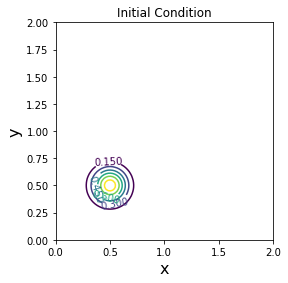

In [24]:
# define initial condition   
def ic(x,y):
    # initial distribution is a gaussian 
    xcenter = 0.5   # location of the gaussian center
    ycenter = 0.5    
    sharpen = 40.0  # increase to sharpen the gaussian
    phi_ic = np.exp(-sharpen*(x - xcenter)**2)*np.exp(-sharpen*(y - ycenter)**2) #+!
    return phi_ic

# plot the initial condition to check that is what you expect...
def ic_plot():
    x = np.linspace(0,L_x,100)
    y = np.linspace(0,L_y,100)
    phi = np.zeros((100, 100)) #initialize, careful with the indices...
    for j in range(100):
        for i in range(100):
            phi[j,i]=ic(x[i],y[j])
    pl.clf()
    # make sure axis have labels  
    X, Y = np.meshgrid(x, y)
    pl.figure()
    pl.gca().set_aspect('equal')
    CS = pl.contour(X, Y, phi)
    pl.clabel(CS, inline=1)
    pl.xlabel("x",fontsize=16) 
    pl.ylabel("y",fontsize=16)  
    pl.title('Initial Condition')
   
ic_plot() 

Some utility functions that will be useful later

In [25]:
# set initial condition   
def initialize(nno_x,nno_y,x,y,phi):
    for j in range(nno_y):
        for i in range(nno_x):
            phi[j,i]=ic(x[i],y[j])

# compute errors
def compute_exact(nno_x,nno_y,time,x,y,phi_exact):
    time_shift_x = time
    time_shift_y = time
    if periodic_x and time*u_x > L_x:
        a = divmod(time,L_x/u_x)
        time_shift_x = a[1]
    if periodic_y and time*u_y > L_y:
        a = divmod(time,L_y/u_y)
        time_shift_y = a[1]
    for j in range(nno_y):
        for i in range(nno_x):
            phi_exact[j,i]=ic(x[i]-u_x*time_shift_x,y[j]-u_y*time_shift_y)

# plot the solution and compare to the exact one
def plot_solution(nno_x,nno_y,x,y,phi,phi_exact):
    pl.clf()
    # make sure axis have labels  
    
    X, Y = np.meshgrid(x, y)
    pl.figure()
    CS = pl.contour(X, Y, phi)
    pl.gca().set_aspect('equal')
    pl.clabel(CS, inline=1)
    pl.xlabel("x",fontsize=16) 
    pl.ylabel("y",fontsize=16)  
    pl.title('Computed Solution')

# compute the L2 norm of the error
def compute_error(nno_x,nno_y,dx,dy,phi,phi_exact):
    error = np.zeros((nno_x,nno_y)) #initialize
    for j in range(nno_y):
        for i in range(nno_x):
            error[j,i]=(phi[j,i]-phi_exact[j,i])
    my_norm = np.sqrt(dx*dy*np.sum(error[1:nno_y-1,1:nno_x-1]**2))     
    return my_norm

## The discretization stencils...
Define the discretization schemes - explicit finite difference stencils

We consider the upwind scheme

$$ \phi^{n+1}_{i,j} = \phi^n_{i,j} - \frac{u_x \Delta t}{\Delta x} \left( \phi_{i,j}^n - \phi_{i-1,j}^n \right)
- \frac{u_y \Delta t}{\Delta y} \left( \phi_{i,j}^n - \phi_{i,j-i}^n \right)$$

and the Lax-Wendroff scheme

$$ \phi^{n+1}_{i,j} = \phi^n_{i,j} - \frac{u_x \Delta t}{2 \Delta x} \left( \phi_{i+1,j}^n - \phi_{i-1,j}^n \right) - \frac{u_y\Delta t}{2 \Delta y} \left( \phi_{i,j+1}^n - \phi_{i,j-1}^n \right) $$
$$ + \left( \frac{u_x \Delta t}{\Delta x} \right)^2 \left( \phi_{i+1,j}^n + \phi_{i-1,j}^n - 2\phi_{i,j}^n \right)  + \left( \frac{u_y \Delta t}{\Delta y} \right)^2 \left( \phi_{i,j+1}^n + \phi_{i,j-1}^n - 2\phi_{i,j}^n \right) $$

In [26]:
# First Order Upwind
def update_upwind(nno_x,nno_y,dx,dy,dt,phi):
    phi_old = phi.copy() 
    for j in range(1, nno_y-1):
        jm = j-1
        for i in range(1, nno_x-1):
            im = i-1
            phi[j,i] = phi_old[j,i] -dt*(u_x/dx*(phi_old[j,i] - phi_old[j,im])
                                        +u_y/dy*(phi_old[j,i] - phi_old[jm,i]))
    
# Lax Wendroff
def update_laxwendroff(nno_x,nno_y,dx,dy,dt,phi):
    phi_old = phi.copy() 
    for j in range(1, nno_y-1):
        jm = j-1
        jp = j+1
        for i in range(1, nno_x-1):
            im = i-1
            ip = i+1
            phi[j,i] = phi_old[j,i]-(
                      0.5*u_x*dt/dx*(phi_old[j,ip]-phi_old[j,im])
                     +0.5*u_y*dt/dy*(phi_old[jp,i]-phi_old[jm,i])
                     -0.5*u_x*dt/dx*u_x*dt/dx*(-2.*phi_old[j,i]+phi_old[j,im]+phi_old[j,ip])
                     -0.5*u_y*dt/dy*u_y*dt/dy*(-2.*phi_old[j,i]+phi_old[jm,i]+phi_old[jp,i]) )

# add your own...

Boundary conditions and the actual time integration loop

In [27]:
# set boundary condition (only for periodicity, otherwise the IC is OK)
def bc(nno_x,nno_y,x,y,phi,time):
    if (periodic_x):
        for j in range(1, nno_y-1):
            phi[j,0]=phi[j,nno_x-2] #apply periodicity @ x=0
            phi[j,nno_x-1]=phi[j,1] #apply periodicity @ x=L_x
    else:
        for j in range(1, nno_y-1):
            phi[j,0]=ic(x[0]-u_x*time,y[j]-u_y*time) #ncross the left boundary
            #phi[j,nno_x-1]=phi[j,nno_x-2] #zero-gradient?
            phi[j,nno_x-1]=ic(x[nno_x-1]-u_x*time,y[j]-u_y*time) #cross the right boundary
    if (periodic_y):
        for i in range(1, nno_x-1):
            phi[0,i]=phi[nno_y-2,i] #apply periodicity @ y=0
            phi[nno_y-1,i]=phi[1,i] #apply periodicity @ y=L_y
    else:
        for i in range(1, nno_x-1): 
            phi[0,i]=ic(x[i]-u_x*time,y[0]-u_y*time) #ncross the bottom boundary
            phi[nno_y-1,i]=ic(x[i]-u_x*time,y[nno_y-1]-u_y*time) #cross the right boundary
            
            
# solve the PDE
def solve(nno_x,nno_y,scheme="upwind",plot=1):  
    #by default use upwind and plot solution
    dx = L_x / (nno_x-1)    # spacing of the nodes
    dy = L_y / (nno_y-1)     
    x = np.linspace(0,L_x,nno_x)  #grid generation!
    y = np.linspace(0,L_y,nno_y)   
    phi       = np.zeros((nno_x, nno_y))        #initialize, careful with the indices...
    phi_exact = np.zeros((nno_x, nno_y))  
    initialize(nno_x,nno_y,x,y,phi) #initialize
    time = 0
    nts = 0
    dt = cfl/(u_x/dx+u_y/dy)
    while time < T:  #integrate up to time T
        bc(nno_x,nno_y,x,y,phi,time)
        nts = nts + 1
        time = time + dt  
        # update the solution with a finite difference scheme (explicit)
        if scheme == "upwind": 
            update_upwind(nno_x,nno_y,dx,dy,dt,phi)
        elif scheme == "laxwendroff":
            update_laxwendroff(nno_x,nno_y,dx,dy,dt,phi)
    # compare the solution with the exact and compute the L2 norm
    compute_exact(nno_x,nno_y,time,x,y,phi_exact)
    enorm = compute_error(nno_x,nno_y,dx,dy,phi,phi_exact)
    if plot:
        plot_solution(nno_x,nno_y,x,y,phi,phi_exact)
    return dx,dy,enorm

## Let's compute something
Start with upwind 

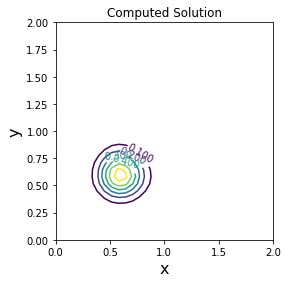

In [28]:
none, none, none = solve(32,32,"upwind",1)

Now Lax-Wendroff

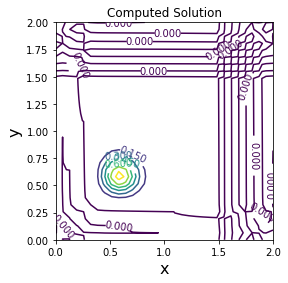

In [29]:
none, none, none = solve(32,32,"laxwendroff",1)

## Grid Convergence Study
Perform a quantitative analysis of the error. Using multiple grids and compare the L2 norm reduction. 

In [30]:
# set up a sequence of grids
ngrids = 4
n = [16,32,64,128]
delta = np.zeros(ngrids)
l2_upwind = np.zeros(ngrids)
l2_laxwendroff = np.zeros(ngrids)
nr = np.array(n, dtype=np.float64)  # make this real for plotting

# perform the simulations on each grid with different FD schemes
for ig in range(ngrids):
    delta[ig],delta[ig],l2_upwind[ig] = solve(n[ig],n[ig],"upwind",0)
    delta[ig],delta[ig],l2_laxwendroff[ig] = solve(n[ig],n[ig],"laxwendroff",0)
    print "Grid ",ig," Delta_x/Delta_y = ",delta[ig]," Error =",l2_upwind[ig],l2_laxwendroff[ig]

Grid  0  Delta_x/Delta_y =  0.133333333333  Error = 0.0810080700634 0.0578698746734
Grid  1  Delta_x/Delta_y =  0.0645161290323  Error = 0.0515095332033 0.0184858378855
Grid  2  Delta_x/Delta_y =  0.031746031746  Error = 0.0290109729205 0.00477692837523
Grid  3  Delta_x/Delta_y =  0.0157480314961  Error = 0.0153929073745 0.00128860757332


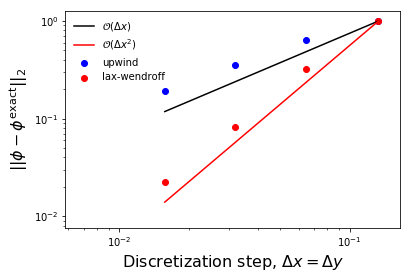

In [15]:
# plot the classical convergence diagram with first & second order slopes
pl.clf()
pl.scatter(delta, l2_upwind/l2_upwind[0],color="b", label="upwind")
pl.scatter(delta, l2_laxwendroff/l2_laxwendroff[0],color="r", label="lax-wendroff")
pl.plot(delta,(delta/delta[0]),color="k",label=r"$\mathcal{O}(\Delta x)$")
pl.plot(delta,((delta/delta[0])**2),color="r",label=r"$\mathcal{O}(\Delta x^2)$")
ax = pl.gca()
ax.set_xscale('log')
ax.set_yscale('log')
pl.xlabel(r"Discretization step, $\Delta x = \Delta y $",fontsize=16)
pl.ylabel(r"$\|| \phi - \phi^\mathrm{exact} \||_2$",fontsize=16)
pl.legend(frameon=False);

## Further work
Change the velocity field to a solid-body rotation